In [13]:
import openslide
from pathlib import Path
import os
import sys
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
from PIL import Image
sys.path.insert(0, '../Utils/')
from Utils import get_downsample_factor, get_image_at_target_mag

In [2]:
print(openslide.__version__)

1.3.1


In [3]:
def generate_deepzoom_tiles(slide, save_image_size, pixel_overlap, limit_bounds):
    # this is physical microns per pixel
    acq_mag = 10.0/float(slide.properties[openslide.PROPERTY_NAME_MPP_X])

    # this is nearest multiple of 20 for base layer
    base_mag = int(20 * round(float(acq_mag) / 20))

    # this is how much we need to resample our physical patches for uniformity across studies
    physSize = round(save_image_size*acq_mag/base_mag)

    # grab tiles accounting for the physical size we need to pull for standardized tile size across studies
    tiles = DeepZoomGenerator(slide, tile_size=physSize-round(pixel_overlap*acq_mag/base_mag), overlap=round(pixel_overlap*acq_mag/base_mag/2), 
                              limit_bounds=limit_bounds)

    # calculate the effective magnification at each level of tiles, determined from base magnification
    tile_lvls = tuple(base_mag/(tiles._l_z_downsamples[i]*tiles._l0_l_downsamples[tiles._slide_from_dz_level[i]]) for i in range(0,tiles.level_count))

    return tiles, tile_lvls, physSize, base_mag


In [4]:
################################################
#Create output dir
################################################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'

In [5]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 100
mag_extract = 20
limit_bounds = True
TOP_K = 5

In [6]:
#Load slide
pt = "OPX_005"
print(pt)

_file = wsi_path + pt + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))

OPX_005


In [7]:
#Generate tiles
tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)

In [8]:
tile = tiles.get_tile(tile_lvls.index(mag_extract), (20, 50))

In [9]:
import openslide
from PIL import ImageCms, Image
srgb_profile = ImageCms.createProfile("sRGB")

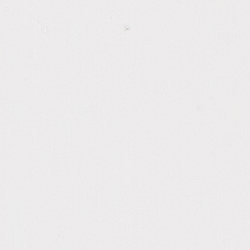

In [10]:
converted_image = ImageCms.profileToProfile(tile, srgb_profile, srgb_profile)
converted_image

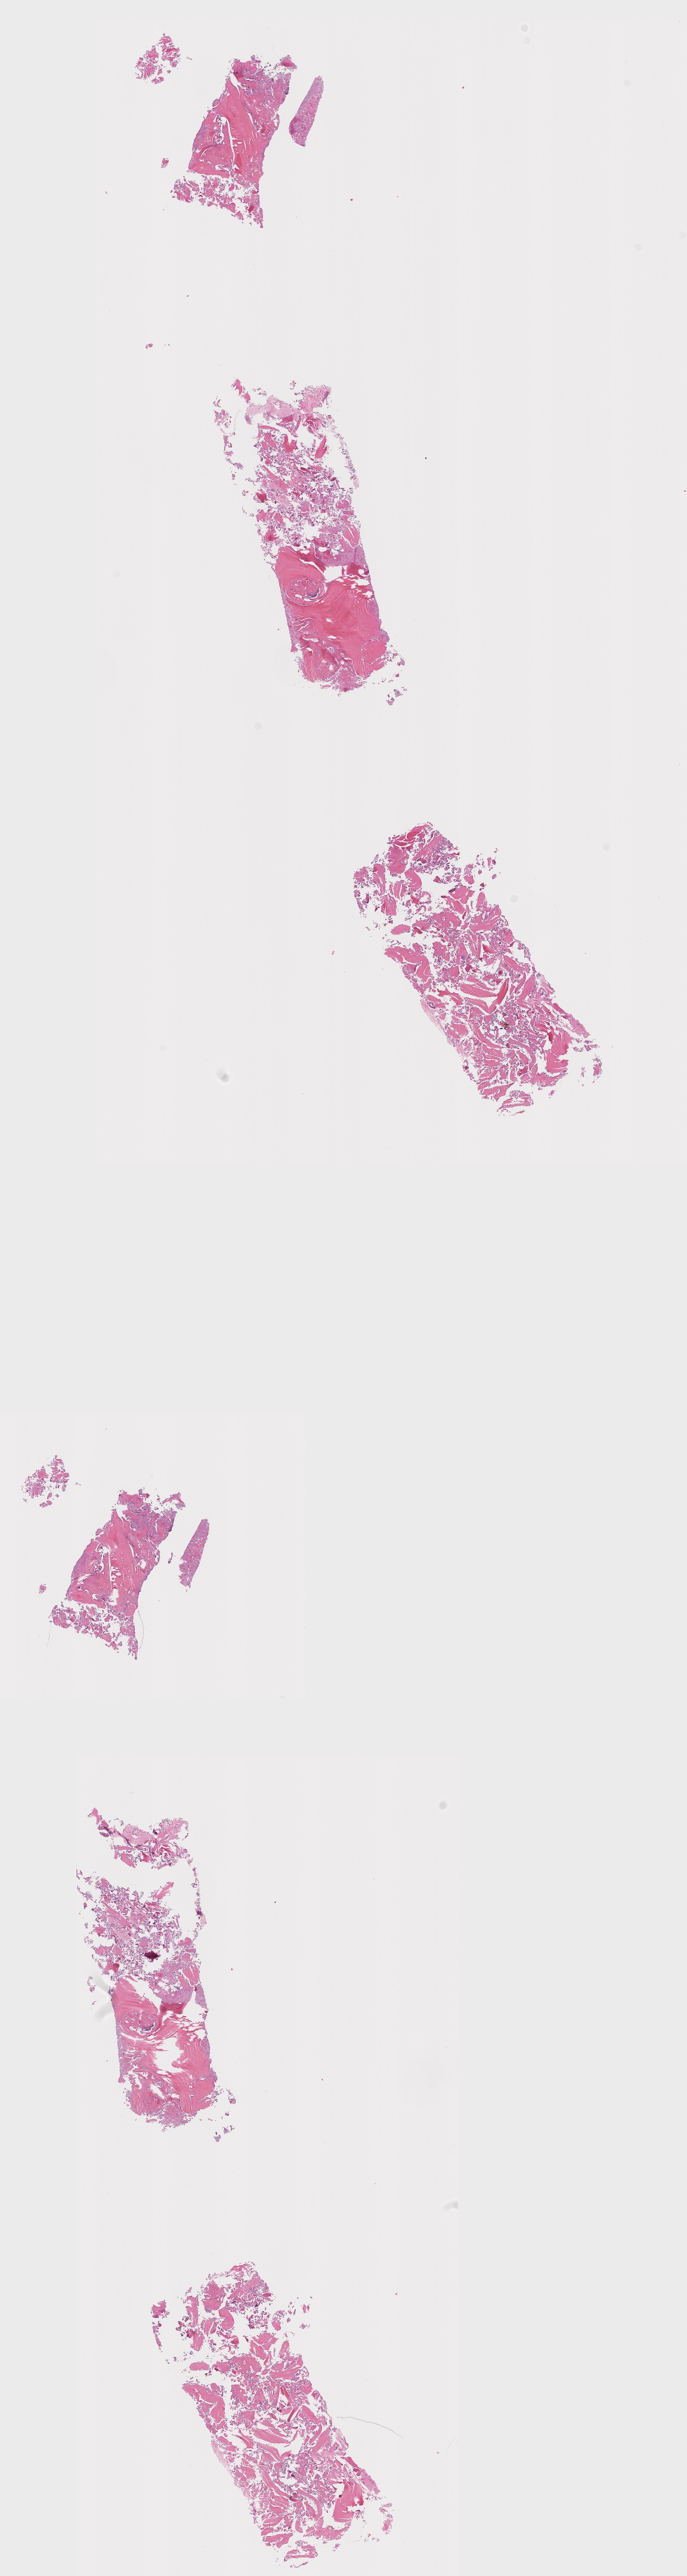

In [18]:
mag_target_tiss = 1.25
#get level 0 size in px
l0_w = oslide.level_dimensions[0][0]
l0_h = oslide.level_dimensions[0][1]
lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize)

lvl_img = ImageCms.profileToProfile(lvl_img, srgb_profile, srgb_profile)
lvl_img